In [35]:
import pickle
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.optimizers import Nadam
from keras.models import Model
import numpy as np
from sklearn.manifold import TSNE
from metrics import precision, recall, f1
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [1]:
params = {
  'ACTIVATION_FN': 'relu',
  'BATCH_SIZE': 64,
  'EMBEDDING_DIM': 100,
  'EPOCHS': 100,
  'LR': 0.001,
  'MAX_NB_WORDS': 10000,
  'MAX_SEQUENCE_LENGTH': 300,
  'NUM_CLASSES': 90,
  'NUM_DENSE': 200,
  'NUM_LSTM': 300,
  'PATIENCE': 2,
  'RATE_DROP_DENSE': 0.2,
  'RATE_DROP_LSTM': 0.2,
  'VALIDATION_SPLIT': 0.2,
  'metrics_acc': 0.77012255713812516,
  'metrics_f1': 0.77711240909775625,
  'metrics_loss': 7.148816829092576,
  'metrics_prec': 0.81774655224802373,
  'metrics_rec': 0.76228632478632474,
}

### Load the data

In [25]:
dataset_filename = "dataset/dataset-NB_WORDS_10000_MAX_SEQ_LENGTH_300.pkl".format(
    params['MAX_NB_WORDS'],
    params['MAX_SEQUENCE_LENGTH']
)

print("Searching for dataset file {}".format(dataset_filename))
try:
    file_content = pickle.load(open(dataset_filename, "rb"))
except (OSError, IOError):
    print("File not found")
else:
    print("File found")
train_sequences, train_categories, test_sequences, test_categories, train_fileids, test_fileids, word_index = file_content
all_sequences = np.concatenate((train_sequences, test_sequences))
all_fileids = np.concatenate((train_fileids, test_fileids))
all_categories = np.concatenate((train_categories, test_categories))

Searching for dataset file dataset/dataset-NB_WORDS_10000_MAX_SEQ_LENGTH_300.pkl
File found


### Build models
The full model and the one used to extract documents representations

In [20]:
def make_model(params, word_index):
    """Builds the model"""
    embedding_layer = Embedding(
        input_dim=params['MAX_NB_WORDS'],
        output_dim=params['EMBEDDING_DIM'],
        input_length=params['MAX_SEQUENCE_LENGTH'])
    lstm_layer = LSTM(params['NUM_LSTM'], dropout=params['RATE_DROP_LSTM'], recurrent_dropout=params['RATE_DROP_LSTM'])

    sequence_1_input = Input(shape=(params['MAX_SEQUENCE_LENGTH'],), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    merged = lstm_layer(embedded_sequences_1)

    merged = Dense(params['NUM_DENSE'], activation=params['ACTIVATION_FN'])(merged)
    merged = Dropout(params['RATE_DROP_DENSE'])(merged)

    preds = Dense(params['NUM_CLASSES'], activation='sigmoid')(merged)

    model = Model(inputs=[sequence_1_input], outputs=preds)
    model.compile(
        loss='binary_crossentropy',
        optimizer=Nadam(lr=params['LR']),
        metrics=['acc', precision, recall, f1]
    )
    model.summary()
    model_bis = Model(inputs=[sequence_1_input], outputs=merged)
    return model, model_bis
model, model_bis = make_model(params, word_index)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               481200    
_________________________________________________________________
dense_5 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 90)                18090     
Total params: 1,559,490
Trainable params: 1,559,490
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.load_weights("model-20171214-121501.h5")

In [26]:
REPR_PATH = "model-20171214-121501-representations.pkl"
try:
    all_representations, _ = pickle.load(open(REPR_PATH, "rb"))
except (OSError, IOError):
    print("Representations not found, computing them now")
    all_representations = model_bis.predict(all_sequences)
    pickle.dump((all_representations, all_fileids), open(REPR_PATH, "wb"))

In [30]:
n_sne = 7000

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(all_representations)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10788 samples in 0.254s...
[t-SNE] Computed neighbors for 10788 samples in 33.938s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10788
[t-SNE] Computed conditional probabilities for sample 2000 / 10788
[t-SNE] Computed conditional probabilities for sample 3000 / 10788
[t-SNE] Computed conditional probabilities for sample 4000 / 10788
[t-SNE] Computed conditional probabilities for sample 5000 / 10788
[t-SNE] Computed conditional probabilities for sample 6000 / 10788
[t-SNE] Computed conditional probabilities for sample 7000 / 10788
[t-SNE] Computed conditional probabilities for sample 8000 / 10788
[t-SNE] Computed conditional probabilities for sample 9000 / 10788
[t-SNE] Computed conditional probabilities for sample 10000 / 10788
[t-SNE] Computed conditional probabilities for sample 10788 / 10788
[t-SNE] Mean sigma: 1.098068
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.905113
[t-SNE] E

### Interactive visualization

In [31]:
def show_class(b1=0):
    #b1 = 24
    b2 = b1 + 1
    subset = (all_categories[:, b1:b2].sum(axis=1) > 0)
    vis_x = tsne_results[:, 0]#[np.any(np.logical_and(test_categories > b1, test_categories < b2), axis=1)]
    vis_y = tsne_results[:, 1]#[np.any(np.logical_and(test_categories > b1, test_categories < b2), axis=1)]

    colors = np.zeros((len(all_categories),),)
    colors[subset] = 10
    plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap("jet", 10))
    #plt.colorbar(ticks=range(90))
    plt.clim(-0.5, 9.5)
    plt.show()

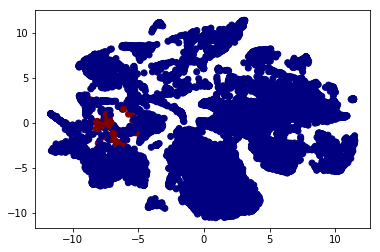

In [36]:
interactive_plot = interactive(show_class, b1=(0, 89, 1), style="width:300px")
interactive_plot